In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from astropy.time import Time
from astroquery.jplsbdb import SBDB

from precovery.orbit import Orbit
from precovery.orbit import EpochTimescale


result = SBDB.query("2022 SF289", full_precision=True, phys=True, cache=False)

# Extract the epoch into a Time object
epoch = Time(result["orbit"]["epoch"], scale="tdb", format="jd")
epoch_tt_mjd = epoch.tt.mjd

# Extract physical characteristics if they exit
if "phys_par" in result:
    if "H" in result["phys_par"]:
        H = result["phys_par"]["H"]
    else:
        H = 20.0

    if "G" in result["phys_par"]:
        G = result["phys_par"]["G"]
    else:
        G = 0.15

# Define a precovery orbit
orbit = Orbit.cometary(
    0,
    result["orbit"]["elements"]["q"].value,
    result["orbit"]["elements"]["e"],
    result["orbit"]["elements"]["i"].value,
    result["orbit"]["elements"]["om"].value,
    result["orbit"]["elements"]["w"].value,
    result["orbit"]["elements"]["tp"].value - 2400000.5,
    epoch_tt_mjd,
    EpochTimescale.TT,
    H, 
    G,
)

In [2]:
from precovery.main import precover

results = precover(
    orbit, 
    "/mnt/data/projects/precovery/precovery_data", 
    allow_version_mismatch=True, 
    tolerance=1/3600,
)

Running version: 0.2.dev160+g9988cf8
Database version: 0.2.dev159+gc091c7b
allow_version_mismatch=True, so continuing.


INFO:precovery:precovering orbit 0 from 56193.15343 to 60125.48419, window=7, datasets=all


In [3]:
from precovery.utils import candidates_to_dataframe, frames_to_dataframe

df = candidates_to_dataframe(results[0])
df_frames = frames_to_dataframe(results[1])
df.to_csv('2022SF289_candidates.csv', index=False)
df

,mjd,ra_deg,dec_deg,ra_sigma_arcsec,dec_sigma_arcsec,mag,mag_sigma,exposure_mjd_start,exposure_mjd_mid,filter,...,observation_id,healpix_id,pred_ra_deg,pred_dec_deg,pred_vra_degpday,pred_vdec_degpday,delta_ra_arcsec,delta_dec_arcsec,distance_arcsec,dataset_id
0,59839.191042,308.640193,26.013307,NaN,NaN,19.222570,0.113389,59839.190868,59839.191042,g,...,2085190862115015005,3456829565,308.640188,26.013357,1.961466,1.459306,0.019370,-0.177586,0.178437,ztf
1,59841.190694,312.286736,28.418773,NaN,NaN,19.429108,0.121851,59841.190521,59841.190694,g,...,2087190525115015013,3460551066,312.286816,28.418827,1.490690,0.989284,-0.289475,-0.194068,0.320124,ztf
2,59841.268276,312.402074,28.494168,NaN,NaN,19.348467,0.140073,59841.268102,59841.268276,g,...,2087268105115015024,3460705260,312.402111,28.494172,1.486501,0.954190,-0.134933,-0.014087,0.119422,ztf
3,59842.212581,313.819625,29.338485,NaN,NaN,18.911371,0.080517,59842.212407,59842.212581,r,...,2088212405715015033,3461454703,313.819670,29.338498,1.315096,0.816735,-0.162230,-0.045432,0.148541,ztf
4,59842.286794,313.917151,29.397931,NaN,NaN,19.738903,0.172324,59842.286620,59842.286794,g,...,2088286625715015015,3461466515,313.917225,29.397979,1.318155,0.787445,-0.268344,-0.172657,0.290634,ztf
5,59844.288449,316.440089,30.767213,NaN,NaN,19.234938,0.088730,59844.288275,59844.288449,r,...,2090288270115015017,3450799338,316.440123,30.767216,1.060398,0.555349,-0.122950,-0.012562,0.106389,ztf
6,59847.218125,319.363070,32.110216,NaN,NaN,19.510641,0.116759,59847.217951,59847.218125,r,...,2093217953115015007,3454117709,319.363095,32.110187,0.803908,0.356708,-0.088988,0.107030,0.130908,ztf
7,59849.177153,320.966640,32.717832,NaN,NaN,20.272482,0.162734,59849.176979,59849.177153,r,...,2095176972415015012,3453630845,320.966721,32.717794,0.695528,0.270099,-0.292942,0.136307,0.281646,ztf


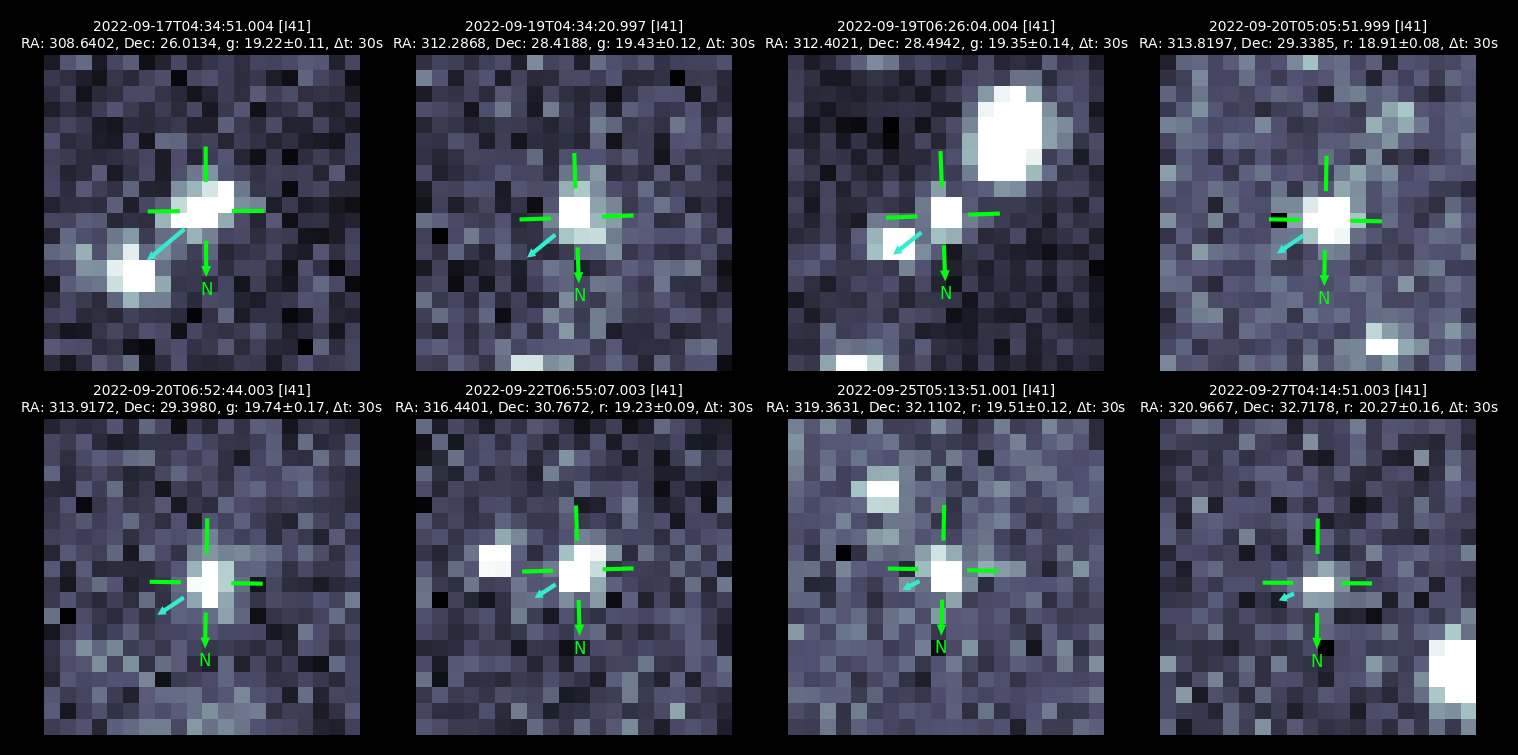

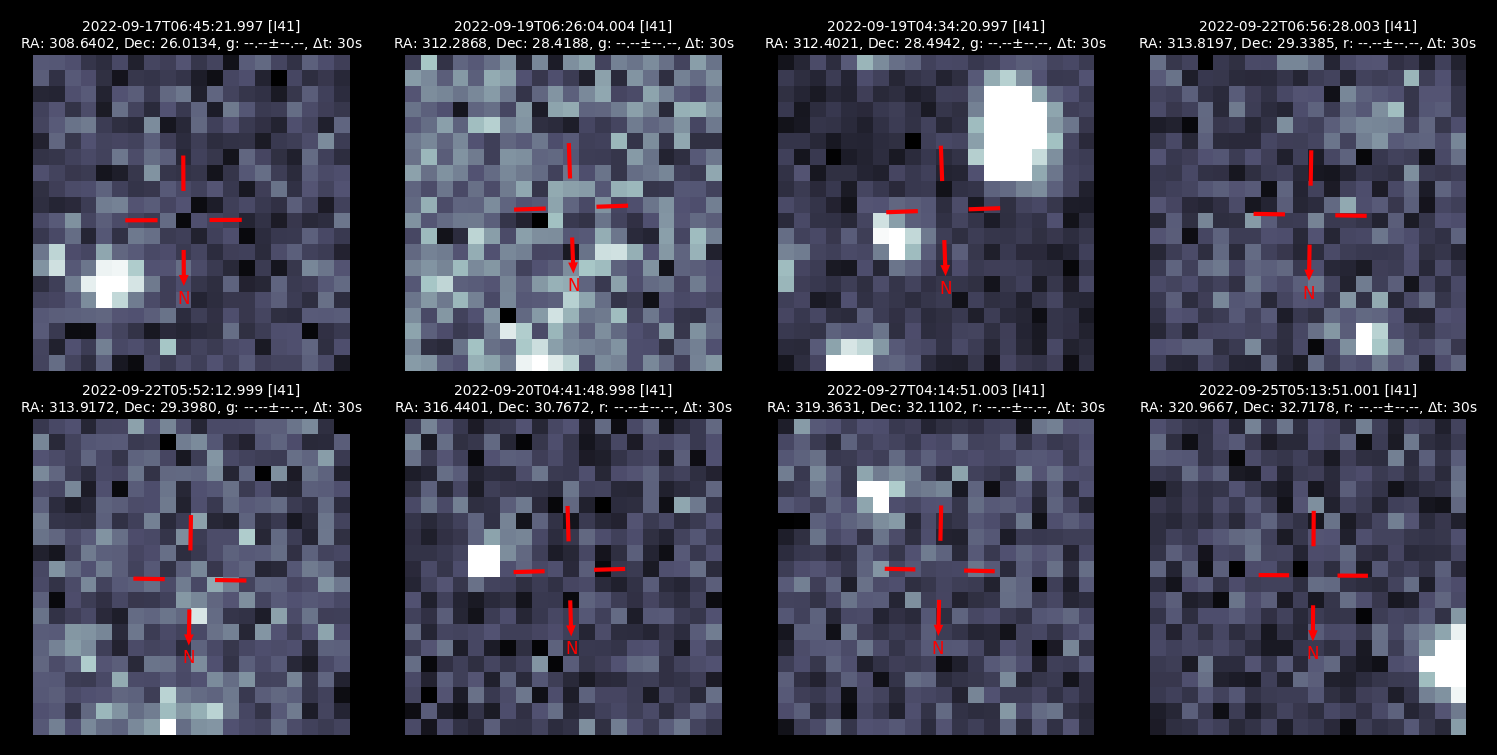

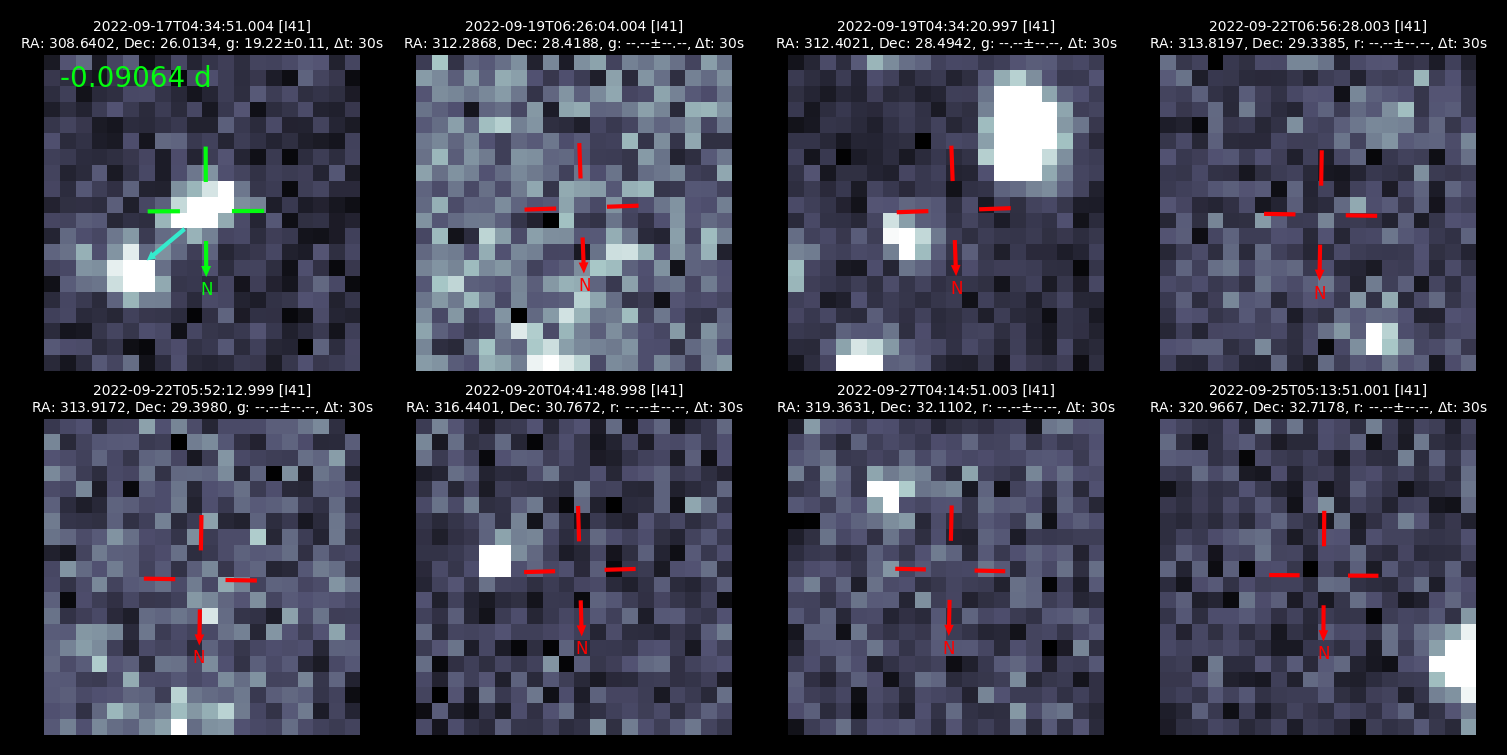

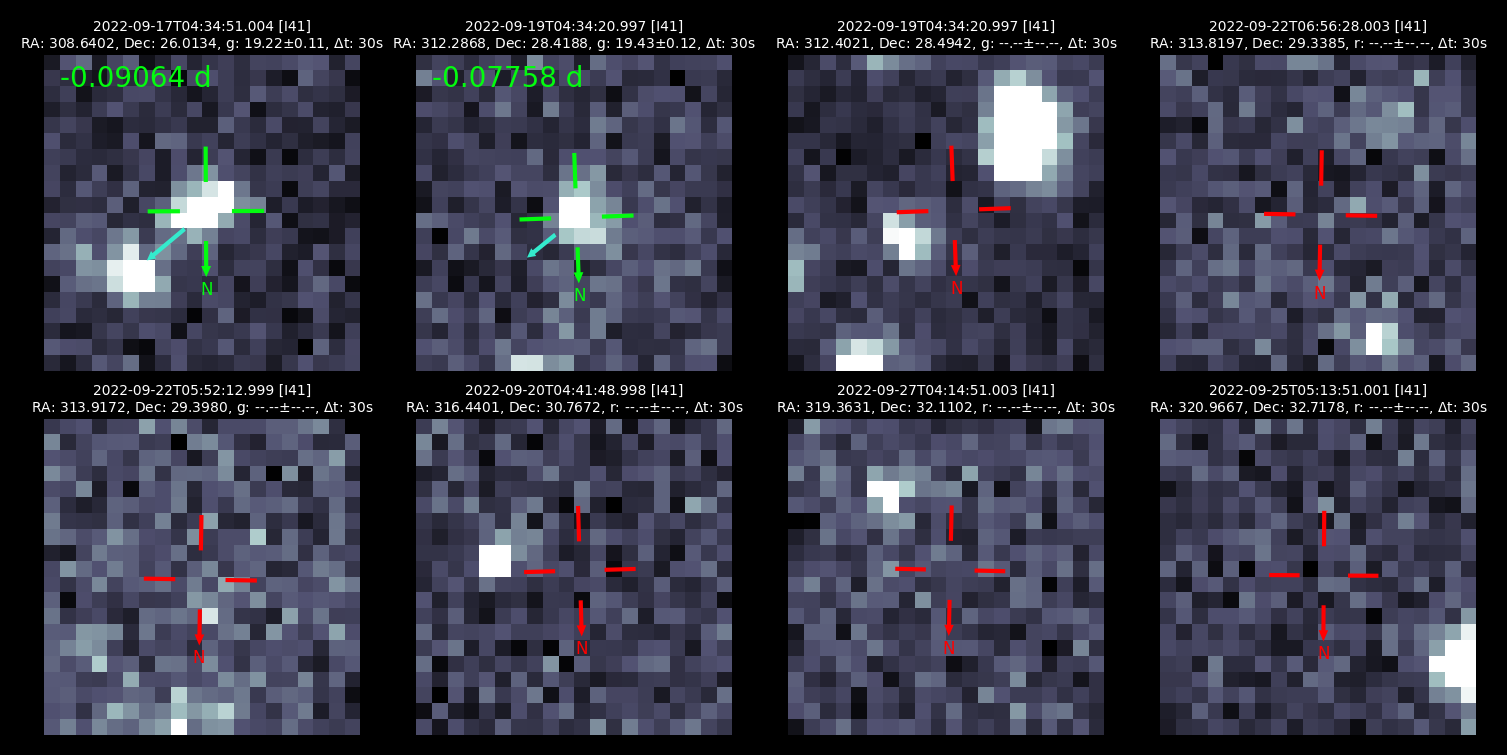

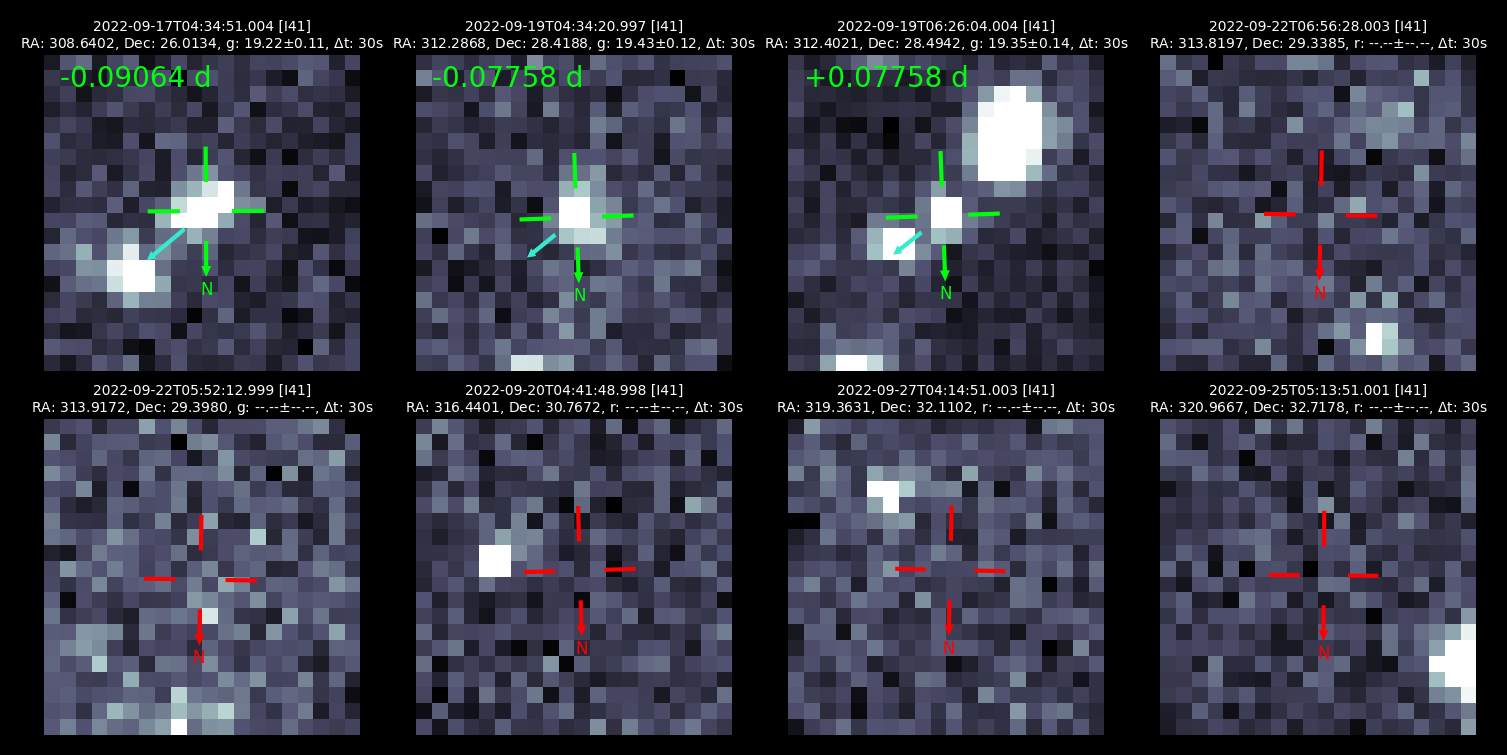

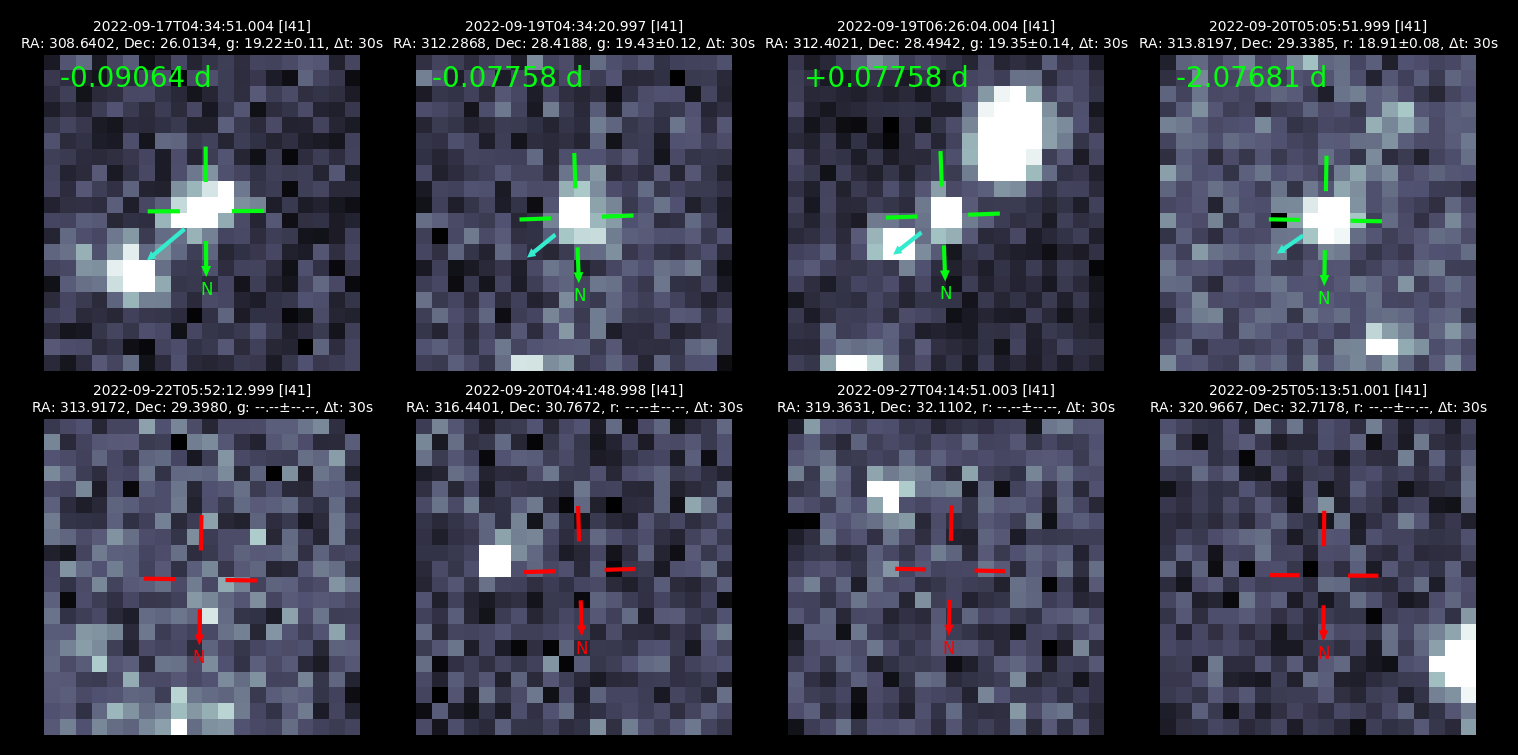

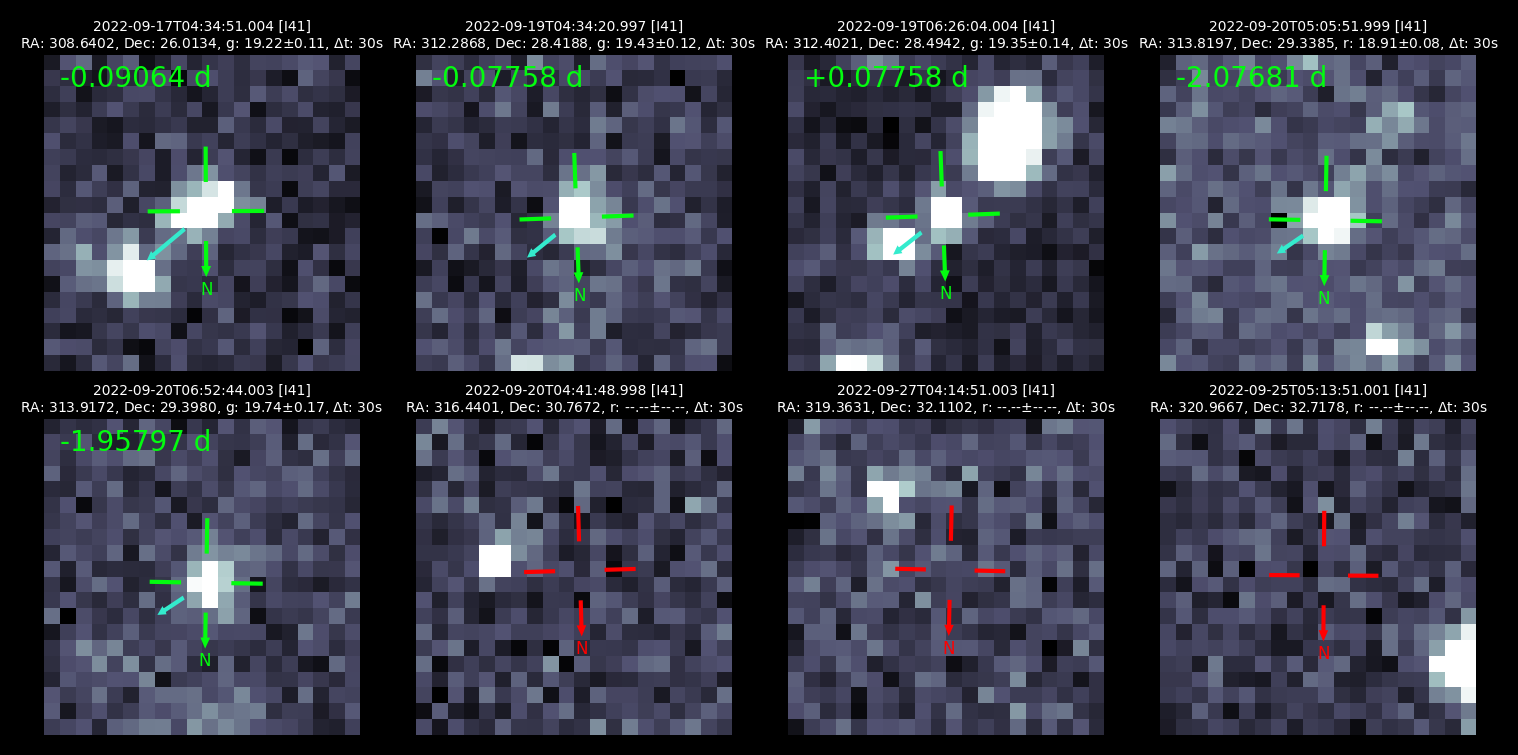

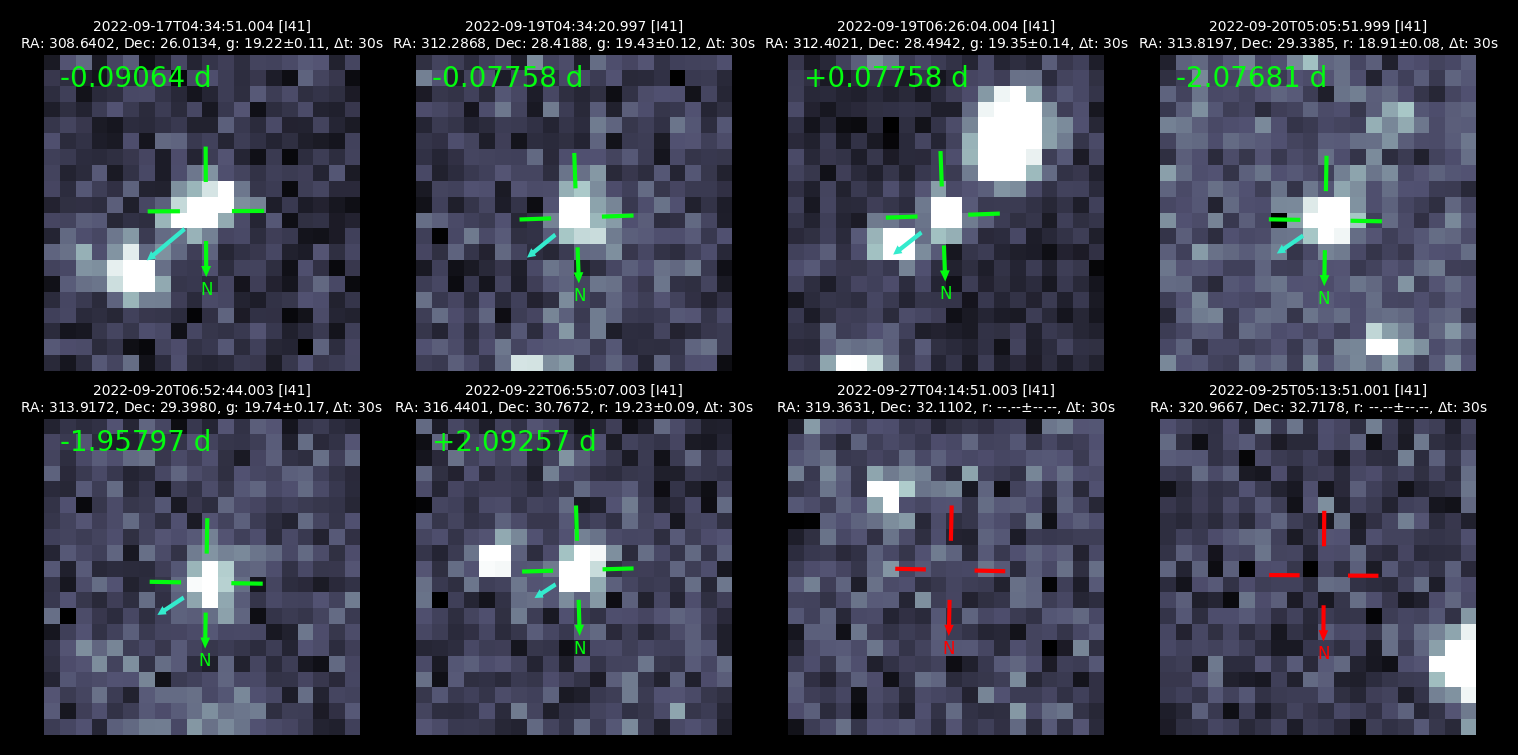

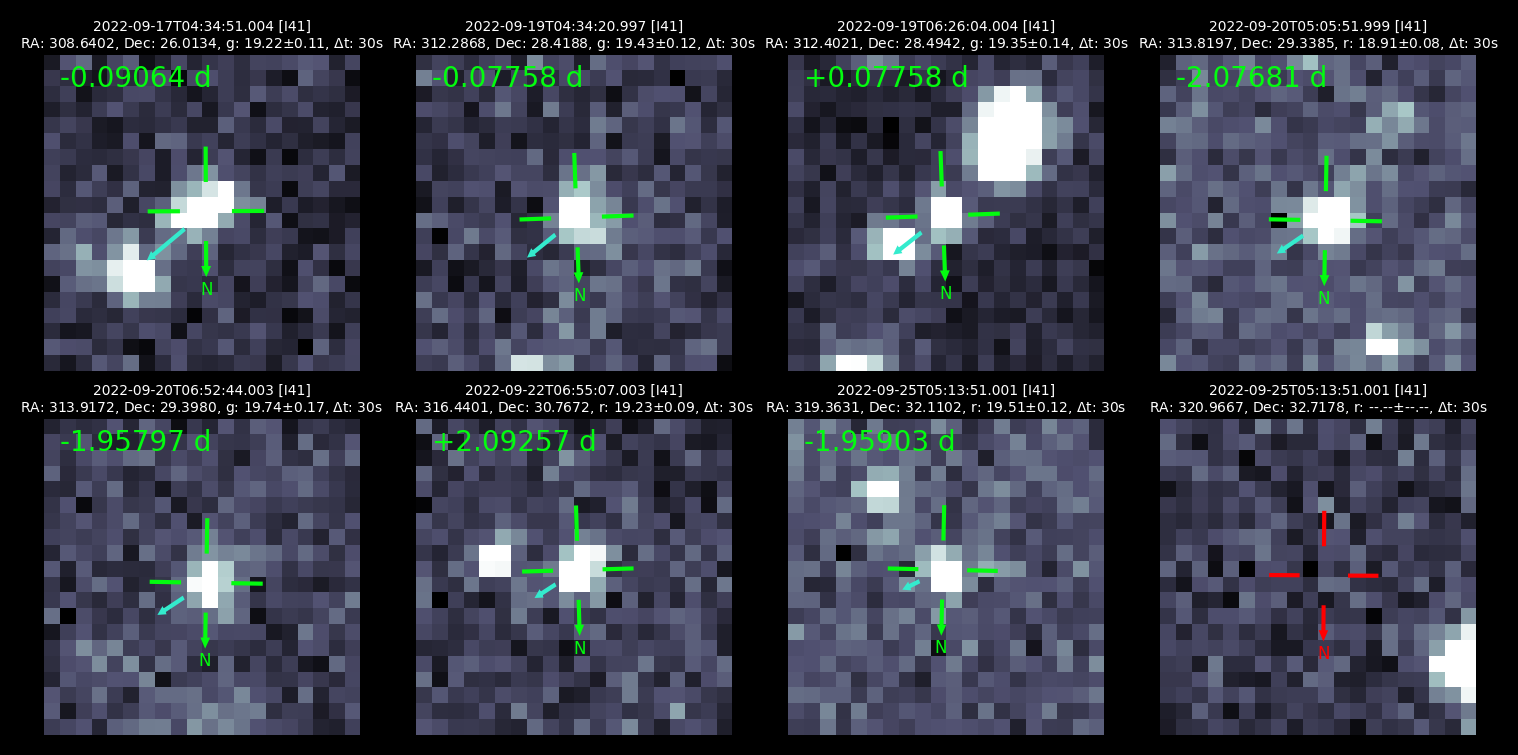

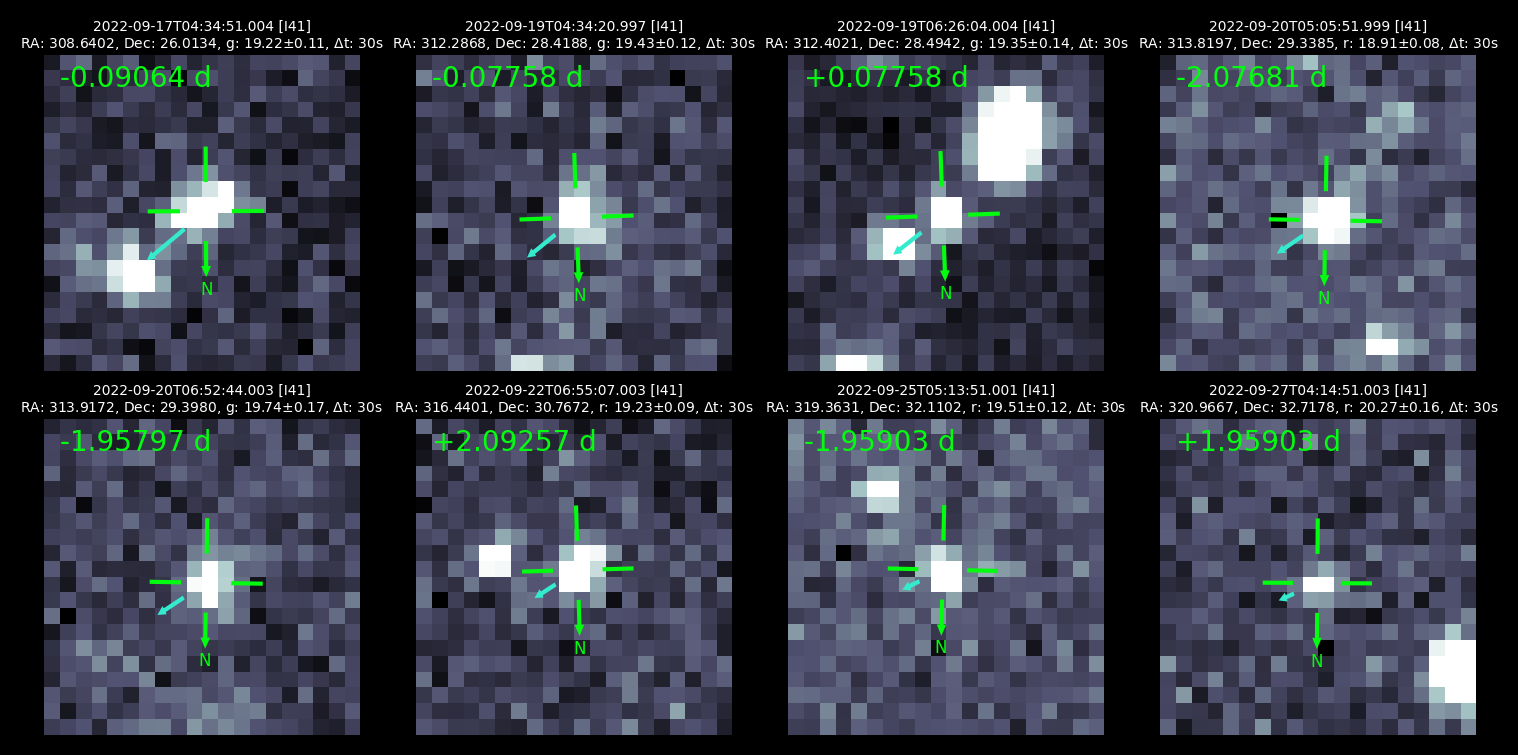

In [4]:
from cutouts.main import run_cutouts_from_precovery

import matplotlib.pyplot as plt
plt.style.use('dark_background')

cutout_results, comparison_results = run_cutouts_from_precovery(
    df, 
    out_dir="cutouts", 
    compare=True, 
    download_full_image=True,
)

In [5]:
from mpcq.client import MPCObservationsClient
from mpcq.utils import observations_to_dataframe


client = MPCObservationsClient.connect_using_gcloud()
mpc_observations = client.get_object_observations("2022 SF289")
mpc_observations = observations_to_dataframe(mpc_observations)

In [6]:
mpc_observations

,mpc_id,status,obscode,filter_band,unpacked_provisional_designation,timestamp,ra,ra_rms,dec,dec_rms,mag,mag_rms,submission_id,created_at,updated_at
0,473050599,Published,T05,Ao,2022 SF289,2022-09-19 08:59:29.172,312.568820,None,28.600600,None,18.61,None,2023-07-17T23:50:01.543_0000FEXe,2023-07-17 23:51:02.785795,2023-07-18 01:02:22.490111
1,473050600,Published,T05,Ao,2022 SF289,2022-09-19 09:04:04.253,312.573270,None,28.603450,None,18.87,None,2023-07-17T23:50:01.543_0000FEXe,2023-07-17 23:51:02.785795,2023-07-18 01:02:22.502347
2,473050601,Published,T05,Ao,2022 SF289,2022-09-19 09:11:59.937,312.581340,None,28.608470,None,19.01,None,2023-07-17T23:50:01.543_0000FEXe,2023-07-17 23:51:02.785795,2023-07-18 01:02:22.503719
3,473050602,Published,T08,Ac,2022 SF289,2022-09-21 08:12:05.463,315.317570,None,30.182190,None,19.37,None,2023-07-17T23:50:28.035_0000FEXf,2023-07-17 23:52:03.505613,2023-07-18 01:02:22.504968
4,473050603,Published,T08,Ac,2022 SF289,2022-09-21 08:24:03.819,315.326730,None,30.187470,None,19.55,None,2023-07-17T23:50:28.035_0000FEXf,2023-07-17 23:52:03.505613,2023-07-18 01:02:22.506647
5,473050604,Published,T08,Ac,2022 SF289,2022-09-21 08:38:33.435,315.338520,None,30.194000,None,19.40,None,2023-07-17T23:50:28.035_0000FEXf,2023-07-17 23:52:03.505613,2023-07-18 01:02:22.507869
6,473050608,Published,T08,Ac,2022 SF289,2022-09-22 08:16:54.722,316.508300,None,30.803860,None,19.66,None,2023-07-17T23:51:01.011_0000FEXh,2023-07-17 23:52:04.530529,2023-07-18 01:02:22.508931
7,473050609,Published,T08,Ac,2022 SF289,2022-09-22 08:32:12.420,316.518710,None,30.809340,None,19.70,None,2023-07-17T23:51:01.011_0000FEXh,2023-07-17 23:52:04.530529,2023-07-18 01:02:22.509966
8,473050610,Published,T08,Ac,2022 SF289,2022-09-22 08:52:27.402,316.533330,None,30.817350,None,19.49,None,2023-07-17T23:51:01.011_0000FEXh,2023-07-17 23:52:04.530529,2023-07-18 01:02:22.511306
9,473050611,Published,T05,Ao,2022 SF289,2022-09-23 08:46:07.787,317.603390,None,31.338230,None,19.36,None,2023-07-17T23:51:34.993_0000FEXi,2023-07-17 23:53:02.725568,2023-07-18 01:02:22.512672


In [7]:
altas_observations = mpc_observations[mpc_observations["obscode"].str.contains("^T[0-9]{2}$")]

ca_time = Time(2459830.389298142, format="jd", scale="tdb")

print(f'Discovery Time: {Time(altas_observations["timestamp"].min(), format="datetime").isot}')
print(f'Close Approach Time: {ca_time.isot}')

Discovery Time: 2022-09-19T08:59:29.172
Close Approach Time: 2022-09-07T21:20:35.359


In [8]:
def create_ADES_header(
    observatory_code,
    submitter,
    telescope_design,
    telescope_aperture,
    telescope_detector,
    observers,
    measurers,
    observatory_name=None,
    submitter_institution=None,
    telescope_name=None,
    telescope_fratio=None,
    object_detection_software=None,
    funding_source=None,
    comment=None,
):
    """
    Write the ADES PSV headers.

    Parameters
    ----------
    observatory_code : str
        MPC-assigned observatory code
    submitter : str
        Submitter's name.
    telescope_design : str
        Telescope's design, eg. Reflector.
    telescope_aperture : str
        Telescope's primary aperture in meters.
    telescope_detector : str
        Telescope's detector, eg. CCD.
    observers : list of str
        First initial and last name (J. Smith) of each of the observers.
    measurers : list of str
        First initial and last name (J. Smith) of each of the measurers.
    observatory_name : str, optional
        Observatory's name.
    submitter_insitution : str, optional
        Name of submitter's institution.
    telescope_name : str, optional
        Telescope's name.
    telescope_fratio : str, optional
        Telescope's focal ratio.
    comment : str
        Additional comment to add to the ADES header.


    Returns
    -------
    list : str
        A list of each line in the ADES header.
    """
    # Start header with version number
    header = [
        "# version=2017",
    ]

    # Add observatory [required]
    header += ["# observatory"]
    header += [f"! mpcCode {observatory_code}"]
    if observatory_name is not None:
        header += [f"! name {observatory_name}"]

    # Add submitter [required]
    header += ["# submitter"]
    header += [f"! name {submitter}"]

    if submitter_institution is not None:
        header += ["! institution {}".format(submitter_institution)]

    # Add telescope details [required]
    header += ["# telescope"]
    if telescope_name is not None:
        header += [f"! name {telescope_name}"]
    header += [f"! design {telescope_design}"]
    header += [f"! aperture {telescope_aperture}"]
    header += [f"! detector {telescope_detector}"]
    if telescope_fratio is not None:
        header += [f"! fRatio {telescope_fratio}"]

    # Add observer details
    header += ["# observers"]
    if type(observers) is not list:
        err = "observers should be a list of strings."
        raise ValueError(err)
    for name in observers:
        header += [f"! name {name}"]

    # Add measurer details
    header += ["# measurers"]
    if type(measurers) is not list:
        err = "measurers should be a list of strings."
        raise ValueError(err)
    for name in measurers:
        header += [f"! name {name}"]

    if object_detection_software is not None:
        header += ["# software"]
        if object_detection_software is not None:
            header += [f"! objectDetection {object_detection_software}"]

    if funding_source is not None:
        header += [f"# fundingSource {funding_source}"]

    # Add comment
    if comment is not None:
        header += ["# comment"]
        header += ["! line {}".format(comment)]

    header = [i + "\n" for i in header]
    return header


def write_ADES_file(
    observations,
    file_out,
    mjd_scale="utc",
    seconds_precision=3,
    columns_precision={
        "ra": 7,
        "dec": 7,
        "mag": 2,
        "rmsMag": 2,
    },
    observatory_code="I41",
    submitter="J. Moeyens",
    telescope_design="Schmidt",
    telescope_aperture="1.2",
    telescope_detector="CCD",
    telescope_name="Oschin Schmidt",
    telescope_fratio="2.44",
    observers=["Z. T. F. Collaboration"],
    measurers=[
        "J. Moeyens", 
        "M. Juric", 
        "K. Kiker", 
        "A. Koumjian", 
        "E. Lu", 
        "S. Nelson", 
        "A. Posner", 
        "N. Tellis"
    ],
    observatory_name="Zwicky Transient Facility",
    submitter_institution="B612 Asteroid Institute",
    object_detection_software="ADAM::Precovery",
    funding_source=None,
    comment=None,
):
    """
    Save observations to a MPC-submittable ADES psv file.

    Parameters
    ----------
    observations : `~pandas.DataFrame`
        Dataframe containing observations.
    file_out : str
        Path and name to save out
    mjd_scale : str, optional
        Time scale of MJD observation times
    seconds_precision : int, optional
        Number of decimal places of precision on the measurement
        of seconds for the observation times. The ADES format can handle higher
        than ms precision if the observations warrant such accuracy. 0.1 ms precision
        would be expressed as 4 while ms precision would be expressed as 3.
    columns_precision : dict, optional
        Dictionary with column names as keys and the precision (in decimals) to which
        they should be printed in the ADES file.
    observatory_code : str, optional
        MPC-assigned observatory code
    submitter : str, optional
        Submitter's name.
    telescope_design : str, optional
        Telescope's design, eg. Reflector.
    telescope_aperture : str, optional
        Telescope's primary aperture in meters.
    telescope_detector : str, optional
        Telescope's detector, eg. CCD.
    observers : list of str, optional
        First initial and last name (J. Smith) of each of the observers.
    measurers : list of str, optional
        First initial and last name (J. Smith) of each of the measurers.
    telescope_name : str, optional
        Telescope's name.
    telescope_fratio : str, optional
        Telescope's focal ratio.
    comment : str, optional
        Additional comment to add to the ADES header.

    Returns
    -------
    list : str
        A list of each line in the ADES header.
    """
    header = create_ADES_header(
        observatory_code,
        submitter,
        telescope_design,
        telescope_aperture,
        telescope_detector,
        observers,
        measurers,
        observatory_name=observatory_name,
        submitter_institution=submitter_institution,
        telescope_name=telescope_name,
        telescope_fratio=telescope_fratio,
        object_detection_software=object_detection_software,
        funding_source=funding_source,
        comment=comment,
    )

    # Format columns from observations into PSV format
    ades = {}

    id_present = False
    if "permID" in observations.columns.values:
        ades["permID"] = observations["permID"].values
        id_present = True
    if "provID" in observations.columns.values:
        ades["provID"] = observations["provID"].values
        id_present = True
    if "trkSub" in observations.columns.values:
        ades["trkSub"] = observations["trkSub"].values
        id_present = True

    if not id_present:
        err = (
            "At least one of permID, provID, or trkSub should\n"
            "be present in observations."
        )
        raise ValueError(err)

    observation_times = Time(
        observations["mjd"].values,
        format="mjd",
        scale=mjd_scale,
        precision=seconds_precision,
    )
    ades["obsTime"] = np.array([i + "Z" for i in observation_times.utc.isot])
    ades["ra"] = observations["ra"].values
    ades["dec"] = observations["dec"].values

    if "rmsRA" in observations.columns.values:
        ades["rmsRA"] = observations["rmsRA"].values
    if "rmsDec" in observations.columns.values:
        ades["rmsDec"] = observations["rmsDec"].values

    ades["mag"] = observations["mag"].values
    if "rmsMag" in observations.columns.values:
        ades["rmsMag"] = observations["rmsMag"].values
    if "rmsTime" in observations.columns.values:
        ades["rmsTime"] = observations["rmsTime"].values
    if "uncTime" in observations.columns.values:
        ades["uncTime"] = observations["uncTime"].values
    ades["band"] = observations["band"].values
    if "exp" in observations.columns.values:
        ades["exp"] = observations["exp"].values.astype(int)
    ades["stn"] = observations["stn"].values
    ades["mode"] = observations["mode"].values
    ades["astCat"] = observations["astCat"].values
    if "photCat" in observations.columns.values:
        ades["photCat"] = observations["photCat"].values

    if "remarks" in observations.columns.values:
        ades["remarks"] = observations["remarks"].values

    for col in columns_precision:
        if col in ades.keys():
            prec_col = columns_precision[col]
            ades[col] = [f"{i:.{prec_col}f}" for i in ades[col]]

    # Create dataframe with formated data entries
    ades = pd.DataFrame(ades)
    col_header = "|".join(ades.columns) + "\n"

    with open(file_out, "w") as f:
        f.write("".join(header))
        f.write(col_header)

    ades = ades.replace(np.nan, " ", regex=True)

    # reduced_precision_cols = ["rmsMag", "uncTime", "rmsTime"]
    reduced_precision_cols = []
    for col in reduced_precision_cols:
        if col in ades.columns:
            ades[col] = ades[col].map(lambda x: "{0:.3f}".format(x))

    ades.to_csv(
        file_out, sep="|", header=False, index=False, mode="a", float_format="%.16f"
    )
    return


In [9]:
import glob
from astropy.io import fits

images = sorted(glob.glob("cutouts/2*.fits"))
for image in images:
    hdu = fits.open(image)[0]
    print(hdu.header["OBSERVER"])
    print(hdu.header["SCAMPFIL"], hdu.header["SCAMPPTH"])

ZTF Robotic Observing Software
gaia_000641_c06_q2.fits /ztf/ops/static/rc21/astrom
ZTF Robotic Observing Software
gaia_000641_c13_q4.fits /ztf/ops/static/rc51/astrom
ZTF Robotic Observing Software
gaia_000641_c13_q4.fits /ztf/ops/static/rc51/astrom
ZTF Robotic Observing Software
gaia_000642_c15_q2.fits /ztf/ops/static/rc57/astrom
ZTF Robotic Observing Software
gaia_000642_c15_q2.fits /ztf/ops/static/rc57/astrom
ZTF Robotic Observing Software
gaia_000688_c01_q2.fits /ztf/ops/static/rc01/astrom
ZTF Robotic Observing Software
gaia_000689_c08_q4.fits /ztf/ops/static/rc31/astrom
ZTF Robotic Observing Software
gaia_000689_c07_q1.fits /ztf/ops/static/rc24/astrom


In [10]:
Time(df["mjd"].values, scale="utc", format="mjd").isot

array(['2022-09-17T04:35:06.004', '2022-09-19T04:34:35.997',
       '2022-09-19T06:26:19.004', '2022-09-20T05:06:06.999',
       '2022-09-20T06:52:59.003', '2022-09-22T06:55:22.003',
       '2022-09-25T05:14:06.001', '2022-09-27T04:15:06.003'], dtype='<U23')

In [11]:
df["provID"] = "2022 SF289"
df["mode"] = "CCD"
df["astCat"] = "Gaia1"  
df_ades = df.rename(
    columns={
        "ra_deg": "ra",
        "dec_deg": "dec",
        "filter": "band",
        "obscode" : "stn",
        "mag_sigma" : "rmsMag",
        "exposure_duration" : "exp",
    },       
)
write_ADES_file(
    df_ades, 
    "2022SF289.ades.psv", 
    funding_source="WilliamBowesFnd, McGregorGirandFund, Tito's Vodka, PRawls, SKraus, Yishan/KWong, SGalitsky, Anon."
)

Querying SBN clone for astrometric catalog declared in ZTF submissions:

```
SELECT DISTINCT astcat, COUNT(astcat) AS num, MIN(obstime), MAX(obstime) FROM obs_sbn WHERE stn = 'I41' GROUP BY astcat ORDER BY num DESC;
```
```
 astcat |   num    |           min           |           max           
--------+----------+-------------------------+-------------------------
 Gaia1  | 13606167 | 2017-12-16 07:26:34     | 2023-07-21 10:10:46.56
 SDSS7  |   997971 | 2009-03-17 03:28:58.368 | 2016-10-06 08:51:28.512
 UCAC2  |    17806 | 2002-10-10 05:41:39.264 | 2018-06-11 09:33:33
 UNK    |    17645 | 2011-06-21 06:47:19.104 | 2016-12-20 02:39:52.128
 Gaia2  |     4420 | 2009-09-20 06:39:52.157 | 2022-12-27 07:49:17
 Gaia3  |     1964 | 2009-03-14 05:12:40.464 | 2022-12-24 12:26:01.248
 USNOB1 |      201 | 2010-08-13 08:06:42.336 | 2021-09-02 09:27:32
 Gaia3E |       72 | 2018-06-06 10:52:44     | 2021-11-11 03:04:09
 PPMXL  |       11 | 2015-03-29 03:21:07.661 | 2015-10-13 11:58:07.507
 UCAC4  |        2 | 2010-09-04 08:04:07.68  | 2010-09-04 09:06:53.856
        |        0 | 2018-07-13 06:27:22     | 2022-12-22 13:29:02.112
(11 rows)
```


Same for photometric catalog (looks to not be reported):
```
mpc_sbn=> SELECT DISTINCT photcat, COUNT(photcat) AS num, MIN(obstime), MAX(obstime) FROM obs_sbn WHERE stn = 'I41' GROUP BY photcat ORDER BY num DESC;
```
```
 photcat | num |           min           |          max           
---------+-----+-------------------------+------------------------
 PS1_DR1 |  67 | 2022-08-20 11:43:39     | 2022-09-27 12:37:38
 Gaia2   |  20 | 2019-09-20 04:34:06     | 2022-10-20 09:13:26.43
         |   0 | 2002-10-10 05:41:39.264 | 2023-07-21 10:10:46.56
```